# Regularized Regression

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA' #add proj name and dataset

In [ ]:
# Calculating Relative Importance
!pip install relativeImp
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
import pandas_gbq
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import TimeSeriesSplit

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculating Relative Importance
from relativeImp import relativeImp
import shap

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics


from google.colab import files


magics.context.project = project_name  #update your project name

client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False

## 1) Import dataset

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update with project name.

In [ ]:
#update file name
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)

#df=df_raw.copy()
df=df_raw.drop(columns=['DIV_WYG_PPl21_0p0_0d0_12'],axis=1).copy()
df.head()


,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,...,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_WYG_PPl21_0p0_0d0_12,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
0,10/13/2023,729,-1.108161,0.178209,-0.774452,0.627772,-0.264759,-0.146654,-0.311050,1.422696,...,-0.690469,-0.398094,-0.624894,-0.189886,-1.329793,-0.263140,-0.970183,0.060408,-0.310528,0
1,10/14/2023,936,-0.591641,-1.339583,-0.210658,-0.060092,1.589453,-0.647853,0.225988,0.828675,...,-0.717841,-0.347162,-0.191100,-0.421855,-0.885066,-0.368436,-0.970183,-0.082952,0.649707,0
2,10/15/2023,787,-1.532171,-1.826123,-1.843573,-1.182772,-1.070458,-1.485678,0.973487,-1.001415,...,-0.772585,-0.827603,-0.320066,-1.336846,-1.405619,-1.460062,-0.970183,-0.144391,-1.107704,0
3,10/16/2023,1030,-0.780518,-1.196795,-0.373532,0.178700,-0.684164,-0.640373,-1.523014,-0.602030,...,-0.714270,-0.075824,1.079373,1.429066,0.473788,0.647186,0.539693,0.026275,-1.216410,0
4,10/17/2023,950,-0.965540,-0.985256,-0.277478,-1.161387,-0.375129,-0.902193,-1.312554,0.123433,...,-0.288221,0.468299,0.529403,1.571362,-0.316369,0.114966,-0.788998,-0.977240,-1.216410,0


In [ ]:
#df.head()

### 1.1) Define KPI column and feature set

In [ ]:
date_col = 'Date' #@param {type:"string"}
df = df.drop(columns = [date_col]) # drop date column since it's not part of the feature set

KPI_COL = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
y = df[KPI_COL]
X = df[df.columns[df.columns != KPI_COL]].values

## 2) Build RBA Model

Create a linear model to measure the impact of digital media (x variables) on conversions (y variable).

Different regularization techniques, such as Ridge or Lasso, can be implemented to adjust for highly correlated features.

### 2.1) Run the model and print evaluation metrics

In [ ]:
train_test_split = ''
test_size = 0.1 #@param {type:"number"}

In [ ]:
if train_test_split == 'Y':

  # separate data into train and test based on fraction of test size
  train_df = df[:round(len(df.index)*(1-test_size))]
  test_df = df[round(len(df.index)*(1-test_size)):]

  # split train and test into x/y columns
  train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
  test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

  train_y = train_df[KPI_COL]
  test_y = test_df[KPI_COL]

  # run the model on the training data
  reg = Ridge().fit(train_x,train_y)

  # eval metrics - r-squared on training data
  print('Training Rsquared: ' , round(reg.score(train_x,train_y),2))
  print('Test Rsquared: ' , round(reg.score(test_x,test_y),2))

  # Generate predictions to calculate MAE, MSE, RMSE
  Y_prediction = reg.predict(test_x)
  print('MAE: ' , round(mean_absolute_error(test_y,Y_prediction),2))
  print('MSE: ', round(mean_squared_error(test_y,Y_prediction),2))
  print('RMSE: ',round(np.sqrt(mean_squared_error(test_y,Y_prediction)),2))

else:
  # run the model on the full dataset
  reg = Ridge().fit(X,y)

  # Generate predictions to calculate residuals
  Y_prediction = reg.predict(X)

  # eval metrics - r-squared on full dataset
  print('R-squared: ',round(reg.score(X,y),2))

R-squared:  0.96


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import numpy as np

# Fit the Ridge model
ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha value as needed
ridge_reg.fit(X, y)

# Predict and calculate R-squared
y_pred = ridge_reg.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')

# Assuming 'train_x' is a DataFrame or you have access to the original DataFrame's column names

dt_X = df[df.columns[df.columns != KPI_COL]]
feature_names = dt_X.columns  # Replace with  DataFrame's columns if 'train_x' is not a DataFrame

# Getting the coefficients from the Ridge model
coefficients = ridge_reg.coef_

# Pairing each feature name with its corresponding coefficient
for feature, coeff in zip(feature_names, coefficients):
    print(f'{feature}: {coeff}')

# Also printing the intercept
print('Intercept:', ridge_reg.intercept_)




R-squared: 0.9644882208528873
Mean Squared Error: 15692.190331433621
C_DIV_BUY_CONNECTEDl21_0p0_0d0_12: -12.304083977524959
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12: -80.49052669602497
C_DIV_BUY_PREMIUMl21_0p0_0d0_12: 41.53369147092971
C_DIV_BUY_SSl21_0p0_0d0_06: 27.407121194434
C_DIV_CONN_DATAl21_0p0_0d0_06: -14.511691412821788
C_DIV_CONN_REMOTEl21_0p0_0d0_12: 26.52304535199936
C_DIV_CONN_TRYl21_0p0_0d0_06: 10.45617206738562
C_DIV_GETNOW_CONNl21_0p0_0d0_06: -14.41380782418924
C_DIV_GETNOW_ESSl21_0p0_0d0_12: -41.171156453237906
C_DIV_GETNOW_PREMl21_0p0_0d0_12: -0.0933397819292077
C_DIV_GETNOW_SSl21_0p0_0d0_12: -28.423646615128632
C_PP_PKG_APP_ACCESSl21_0p0_0d0_12: -10.297657082234691
C_PP_PKG_CONNECTEDl21_0p0_0d0_12: -88.1042255461443
C_PP_PKG_ESSl21_0p0_0d0_12: -22.510182655304135
C_PP_PKG_PREMl21_0p0_0d0_12: 48.60359705011652
C_PP_PKG_REMOTEl21_0p0_0d0_0: 71.62482158411912
C_PP_PKG_SCl21_0p0_0d0_12: -10.744542203911097
C_PP_PKG_SSl21_0p0_0d0_12: -19.0527411173309
DIV_GMOC_SHOP_ESSl21_0p0_0


### 2.2) Cross-validation

In [ ]:
cross_val = 'N' #@param {type:"string"}

In [ ]:
if cross_val == 'Y':
  tscv = TimeSeriesSplit(n_splits = 5)

  # get number of splits
  print('Number of splits: ',tscv.get_n_splits())

  #### Compute average test sets score: ####
  scores = []

  for train_index, test_index in tscv.split(df):
    train_x = df[:len(train_index)].drop(columns = [KPI_COL])
    #train_y = df.y1[:len(train_index)]
    train_y = df[KPI_COL][:len(train_index)]

    test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns = [KPI_COL])
    #test_y = df.y1[len(train_index):len(train_index)+len(test_index)]
    test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

    cv_model = Ridge()
    cv_model.fit(train_x,train_y)

    preds = cv_model.predict(test_x)

    # r-squared for the current fold only
    r2score = cv_model.score(test_x,test_y)
    scores.append(round(r2score,2))
    print('Score: ', scores)
    cv_score = np.mean(scores)
    print('CV Score: ',round(cv_score,2))

## 3) Calculate contribution of each digital tactic

Shap values are a method for interpreting how each feature impacts a model, both locally and globally.

More info can be found [here](https://shap.readthedocs.io/en/latest/index.html)

In [ ]:
## Fit the explainer
explainer = shap.Explainer(reg.predict,X)

## Calculate the shap values
shap_values = explainer(X)

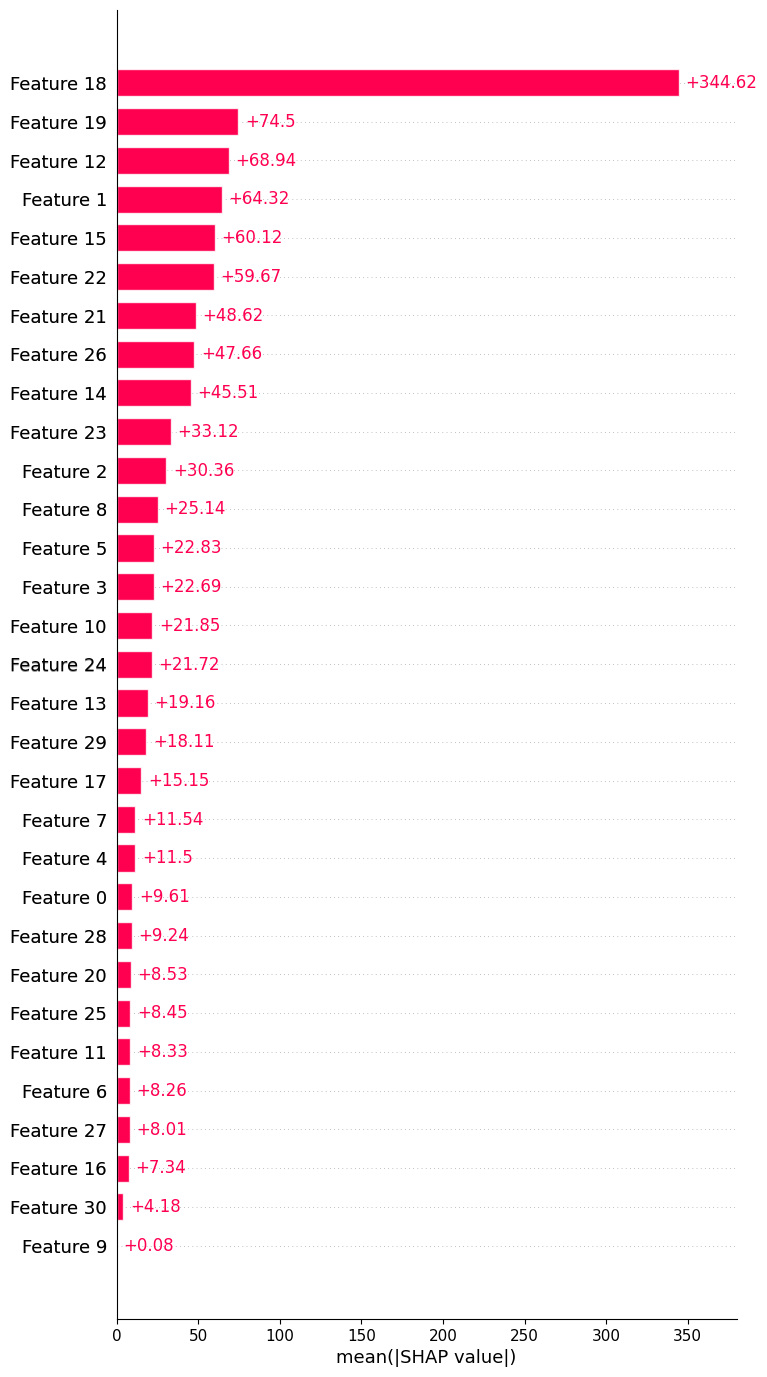

In [ ]:
## shap values
shap.plots.bar(shap_values,max_display = len(df[df.columns[df.columns != KPI_COL]].columns))

In [ ]:
vals= np.abs(shap_values.values).mean(axis = 0)

feature_importance = pd.DataFrame(list(zip(df[df.columns[df.columns != KPI_COL]].columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
18,DIV_GMOC_SHOP_ESSl21_0p0_0d0_0,344.622430
19,DIV_GMOC_SHOP_SSl21_0p0_0d0_0,74.495488
12,C_PP_PKG_CONNECTEDl21_0p0_0d0_12,68.937561
1,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,64.315634
15,C_PP_PKG_REMOTEl21_0p0_0d0_0,60.118221
22,DIV_WYG_PPl21_0p0_0d0_12,59.668655
21,DIV_PLANPAGE_ESSl21_0p0_0d0_0,48.617128
26,OC_PAGE_PREMl21_0p0_0d0_12,47.657966
14,C_PP_PKG_PREMl21_0p0_0d0_12,45.508355
23,OC_APP_Accessl21_0p0_0d0_12,33.118066


In [ ]:
# rescale the shap values to result in a scale rleative to total r-squared

sum_feature_imp = feature_importance.feature_importance_vals.sum()
scale_factor = reg.score(X,y)

feature_importance['attribution'] = feature_importance.feature_importance_vals / (sum_feature_imp / scale_factor)
feature_importance

,col_name,feature_importance_vals,attribution
18,DIV_GMOC_SHOP_ESSl21_0p0_0d0_0,344.622430,0.291785
19,DIV_GMOC_SHOP_SSl21_0p0_0d0_0,74.495488,0.063074
12,C_PP_PKG_CONNECTEDl21_0p0_0d0_12,68.937561,0.058368
1,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,64.315634,0.054455
15,C_PP_PKG_REMOTEl21_0p0_0d0_0,60.118221,0.050901
22,DIV_WYG_PPl21_0p0_0d0_12,59.668655,0.050520
21,DIV_PLANPAGE_ESSl21_0p0_0d0_0,48.617128,0.041163
26,OC_PAGE_PREMl21_0p0_0d0_12,47.657966,0.040351
14,C_PP_PKG_PREMl21_0p0_0d0_12,45.508355,0.038531
23,OC_APP_Accessl21_0p0_0d0_12,33.118066,0.028040


In [ ]:
round(feature_importance.attribution.sum(),2)

0.96

## 4) Validate Linear Regression Model Assumptions

### 4.1) Generate model residuals

In [ ]:
residuals = Y_prediction - y

#Y_prediction
#y

###4.2) Linearity

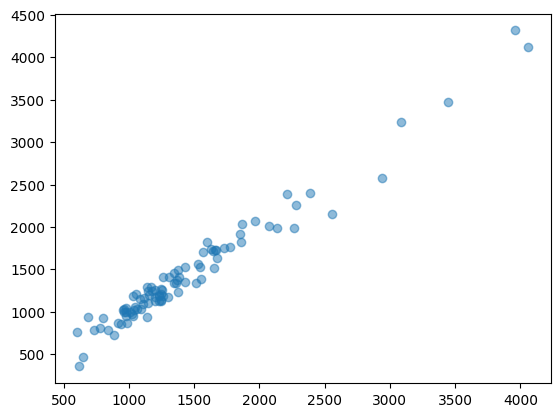

In [ ]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(Y_prediction,y,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

In [ ]:
'''
Visually inspect the residuals to confirm normality
'''

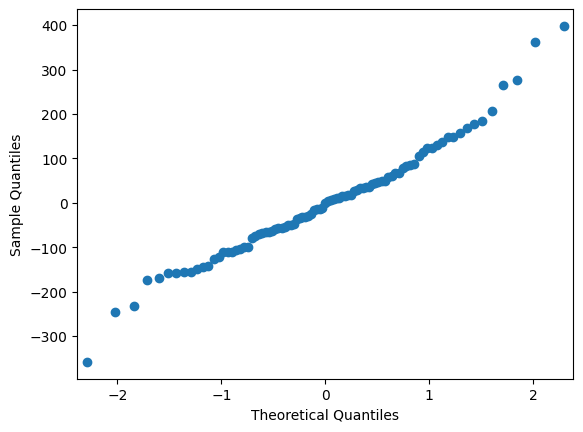

In [ ]:
fig = sm.qqplot(residuals)



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



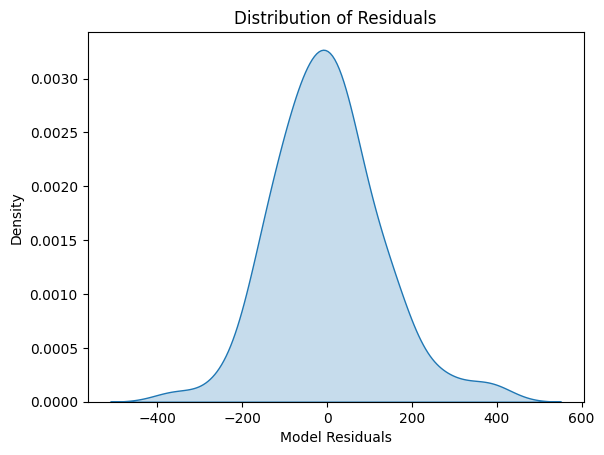

In [ ]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

###4.4) Homoscedasticity


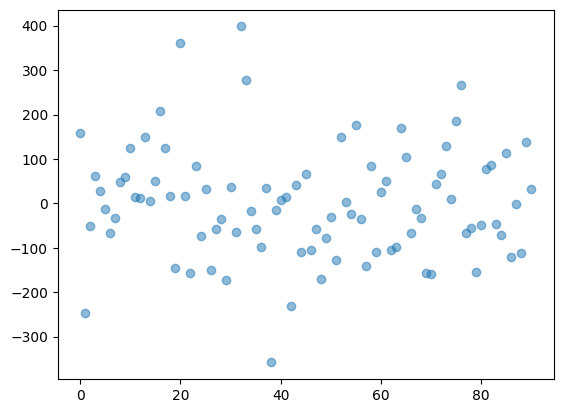

In [ ]:
'''
Visually inspect residuals to confirm constant variance
'''
plt.plot(residuals,'o',alpha=0.5)
plt.show()

###4.5) Residual Autocorrelation Check

In [ ]:
'''
The Durbin Watson test is a statistical test for detecting autocorrelation of the
model residuals
'''

dw = durbin_watson(residuals)
print('Durbin-Watson',dw)

Durbin-Watson 1.913808954849268


In [ ]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Little to no autocorrelation 



In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'X' is your predictors DataFrame

# Assuming 'df' is your DataFrame with all the predictor variables
X = df.drop(columns = [KPI_COL, date_col], axis=1)  # Assuming 'y1' is your target variable

# Add a constant to the model (if it's not already included)
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                                Feature        VIF
0                                 const   1.272314
1     C_DIV_BUY_CONNECTEDl21_0p0_0d0_12   4.339118
2    C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12   4.090112
3       C_DIV_BUY_PREMIUMl21_0p0_0d0_12   2.226793
4            C_DIV_BUY_SSl21_0p0_0d0_06   3.366584
5         C_DIV_CONN_DATAl21_0p0_0d0_06   1.615003
6       C_DIV_CONN_REMOTEl21_0p0_0d0_12   3.556696
7          C_DIV_CONN_TRYl21_0p0_0d0_06   2.023339
8       C_DIV_GETNOW_CONNl21_0p0_0d0_06   2.880305
9        C_DIV_GETNOW_ESSl21_0p0_0d0_12   1.865023
10      C_DIV_GETNOW_PREMl21_0p0_0d0_12   2.487807
11        C_DIV_GETNOW_SSl21_0p0_0d0_12   3.291653
12    C_PP_PKG_APP_ACCESSl21_0p0_0d0_12   2.153091
13     C_PP_PKG_CONNECTEDl21_0p0_0d0_12   5.439887
14           C_PP_PKG_ESSl21_0p0_0d0_12   6.894479
15          C_PP_PKG_PREMl21_0p0_0d0_12   9.778939
16         C_PP_PKG_REMOTEl21_0p0_0d0_0   8.815442
17            C_PP_PKG_SCl21_0p0_0d0_12   2.190947
18            C_PP_PKG_SSl21_0p

## 5) Export Final Results

In [ ]:
final_results_df = feature_importance[['col_name','attribution']]
final_results_df.to_csv('rba_final_output.csv', encoding = 'utf-8-sig')
files.download('rba_final_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>